In the previous [example](./sum_to_n.ipynb), we saw how simply a genetic algorithm could be constructed:

- We initialized a starting population

- Bred the strongest

- Pruned the weak

- And converged to an accurate solution just like that!

This was a much better approach than the brute force method—it solved the problem much faster.

_However_, the simplicity of the previous society won't always suffice!


## __Avoid The Plague__

__Problem:__

We have a `population` of individuals with 1 _pair_ of chromosomes, each of length `n`.
- An individual will express a certain trait (its __phenotype__) based on its combination of alleles (its __genotype__),  
on the same location (__locus__) of each chromosome.

- Each gene on a chromosome will have exactly 2 variants (alleles)

- Capital letters represent _dominant_ alleles, and lowercases represent _recessive_ alleles

- __Recessive__ traits are only expressed in the individual only if it inherits two recessive alleles (one from each parent)

- __Dominant__ alleles override recessive ones, otherwise

A new plague will randomly enter the population.
- It will pick `2x` unique locations (__loci__) on this species' chromosome to target

- Therefore, `2x <= n`

- The disease will be deadly to individuals with specific traits (phenotypes)

- Exactly `x` dominant traits, and `x` recessive traits will be targeted

- Each generation, susceptible adults will be killed—only the children and immune adults survive

__Objective:__ 

Evolve the population of individuals such that all individuals are resistant to the plague.

## __Example__:

Let `n = 5`, `x = 1`

An individual may have the following chromosome pair:

	P: AbcDe
	M: aBcDE

Where P is the paternal chromosome, and M is the maternal chromosome.  
The individual would then have the following genotypes:
- Gene 1 - Aa
- Gene 2 - Bb
- Gene 3 - cc
- Gene 4 - DD
- Gene 5 - Ee

The following traits would be expressed:
- Trait 1 - type A
- Trait 2 - type B
- Trait 3 - type c
- Trait 4 - type D
- Trait 5 - type E

Notice how the dominant (capital letter) alleles are expressed when one is present.  
Otherwise, the recessive allele is expressed.

The plague may target dominant traits at loci 1 (__type A__), 
and recessive traits at loci 3 (__type c__).

Therefore, this individual is susceptible to the plague in 2 different ways &hellip;

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import random
random.seed()

ALPHABET = [chr(c) for c in range(ord('a'), ord('z') + 1)]

In [2]:
class Plague:
	''' New deadly disease attempting to destroy a population. 
	
		Attributes:
		- n (int): length of population DNA
		- x (int): number of loci affected (of each type, dominant or recessive)
		- targets (dict): location of gene affected -> {0, 1} where 0 is recessive, 1 is dominant
	'''
	DOMINANT = 1
	RECESSIVE = 0

	def __init__(self, n, x):
		if x < 1:
			raise ValueError('x must be at least 1')
		if 2*x > n:
			raise ValueError('2x must be <= n, (n is the number of genes on a chromosome)')
		self.n = n
		self.x = x
		self.randomize_targets()

	def randomize_targets(self):
		self.targets = {}
		available_loci = [i for i in range(self.n)]
		for _ in range(self.x):
			loci_left = len(available_loci)
			j = available_loci.pop(random.randrange(loci_left)) # targets dominant trait
			k = available_loci.pop(random.randrange(loci_left-1)) # targets recessive trait
			self.targets[j] = self.DOMINANT
			self.targets[k] = self.RECESSIVE
		self.targets = dict(sorted(self.targets.items())) # sort, ascending loci number

	def __str__(self):
		s = 'Targets'
		for i, trait_type in self.targets.items():
			trait = ALPHABET[i % len(ALPHABET)]
			if trait_type == self.DOMINANT:
				trait = trait.upper()
			s += f'\ngene {i}: {trait}'
		return s

In [3]:
class Individual:
	''' An individual from the plague population.

		Attributes:
		- length (int): Number of genes in a chromosome (string length)
		- chromosomes (tuple<list,list>): 0-paternal, 1-maternal
		- fitness (int): Health of the individual (greater is better)
		- plague (Plague): The disease afflicting the species
	'''
	MUTATION_RATE = 0.05
	HEALTH_UNIT = 5

	def __init__(self, dna_length, plague: Plague, chromosomes=None):
		if dna_length < 3:
			raise ValueError('DNA length too small, {3..26}')
		self.length = dna_length
		self.plague = plague
		if chromosomes is None:
			self.randomize_genes()
		else:
			self.chromosomes = chromosomes
		self.evaluate_fitness()

	def randomize_genes(self):
		# we recycle the alphabet after its length is up
		# capitals are dominant, lowercases are recessive
		limit = len(ALPHABET)
		chrom_1 = []
		chrom_2 = []
		for chrom in [chrom_1, chrom_2]:
			for i in range(self.length):
				c = ALPHABET[i % limit]
				chrom.append(c.upper() if random.random() < 0.5 else c)
		self.chromosomes = (chrom_1, chrom_2)

	def __str__(self):
		''' String representation of an indivdual's chromosomes '''
		s = '1) ' + ''.join(self.chromosomes[0]) + '\n'
		s += '2) ' + ''.join(self.chromosomes[1])
		return s
	
	def _get_genotype(self, loci):
		''' allele combination at a particular chromosome locus '''
		return self.chromosomes[0][loci] + self.chromosomes[1][loci]
	
	def _susceptible(self, loci, target_type):
		''' Is the gene at loci susceptible to the plague? '''
		my_genotype = self._get_genotype(loci) # Aa
		if my_genotype.islower(): # has recessive trait
				if target_type == Plague.RECESSIVE: # susceptible
					return True
		else: # has dominant trait
			if target_type == Plague.DOMINANT: # has harmful dominant trait
				return True
		return False
	
	def evaluate_fitness(self):
		''' The health of an individual will start at 5n,  
		and degrade by 5 pts for each genotype the plague targets. '''
		self.fitness = self.HEALTH_UNIT * self.length
		for i, target_type in self.plague.targets.items():
			if self._susceptible(i, target_type):
				self.fitness -= self.HEALTH_UNIT

	def show_bad_genes(self):
		''' The genotypes that are weakening this individual. '''
		print('Weaknesses:')
		for i, target_type in self.plague.targets.items():
			if self._susceptible(i, target_type):
				print(f'gene {i}: {self._get_genotype(i)}')

	@staticmethod
	def swap_char_case(char):
		# 32 is the distance from 'A' to 'a'
		if 'a' <= char <= 'z':  # lowercase letter
			return chr(ord(char) - 32)
		elif 'A' <= char <= 'Z':  # uppercase letter
			return chr(ord(char) + 32) 
		return char  # non-alphabetic characters
	
	@staticmethod
	def mutate(chromosome):
		''' Chance to mutate each gene on a chromosome, in-place '''
		for i in range(len(chromosome)):
			if random.random() < Individual.MUTATION_RATE:
				chromosome[i] = Individual.swap_char_case(chromosome[i])

	def cross_over(self, other):
		''' Single-point crossover on each parent's pair of chromosomes

		Returns 2 new genomes in a tuple (child_1 chromosomes, child_2 chromosomes)
		''' 
		if self.length != other.length:
			raise ValueError('parents have different DNA lengths')
		children_dna = [[], []] # for child 1 and 2
		for parent in [self, other]:
			# a child will get exactly one chromosome from each parent
			k = random.randint(1, parent.length - 1)
			strand_1 = parent.chromosomes[0][:k] + parent.chromosomes[1][k:]
			strand_2 = parent.chromosomes[1][:k] + parent.chromosomes[0][k:]
			children_dna[0].append(strand_1)
			children_dna[1].append(strand_2)
		return tuple(children_dna)
	
	def procreate(self, other):
		''' Create 2 new children [Individual, Individual] '''
		zygotes = []
		children_dna = self.cross_over(other)
		for dna in children_dna:
			for chrom in dna:
				Individual.mutate(chrom)
			zygotes.append(Individual(self.length, self.plague, chromosomes=dna))
		return zygotes


In [4]:
class Population:
	''' Create a random population with 8 individuals currently undergoing a plague. '''
	def __init__(self, dna_length, plague):
		self.generation = 0
		self.members = [Individual(dna_length, plague) for _ in range(8)]
		self.rank_members()
		
	def rank_members(self):
		''' Sort population in descending order of health. '''
		self.members.sort(reverse=True, key=lambda x : x.fitness)

	def __str__(self):
		s = f'Generation {self.generation}'
		for i, member in enumerate(self.members):
			s += f'\n\tmember {i+1}, health: {member.fitness:>3}'
		return s

	def select(self):
		''' Choose 3 members of the population to be this generation's parents. '''
		return self.members[:3] # top 3 fit

	def evolve(self, n=1, display=False):
		for i in range(n):
			# selection
			parents = self.select()
			children = [] # there will be 6 babies
			for i in range(3):
				for j in range(i+1, 3): # mate with other parents
					children.extend(parents[i].procreate(parents[j]))
			# replacement
			survivors = [] # anyone who is infected dies!
			for member in self.members:
				if member.fitness == (Individual.HEALTH_UNIT * member.length): # max health
					survivors.append(member)
			self.members = survivors + children # only the children and the immune live on
			self.rank_members()
			self.members = self.members[:8] # only track at most 8
			# next generation
			self.generation += 1
			if display:
				print(self)
				print()

Let's count the number of unique chromosome pairs that exist.

A single chromosome has $n$ genes.  
Each gene has exactly $2$ different versions (alleles).

Therefore, a single chromosome has $2^n$ possible structures.

Since an individual has 2 chromosomes of the same type,  
there are $2^n \cdot 2^n = 4^n$ possible chromosome pairs an individual may have.

<br>
Now, let us count the proportion of these chromosome pairs that are _infected_—have at least one trait targeted by the plague.

We will count by complement.

We want to find the number of chromosome pairs that have __no__ traits targeted.

Each gene on each chromosome provides an allele to form a genotype. There are 4 possibilities for each genotype.  
For instance:
- AA
- Aa
- aA
- aa

3 produce a dominant trait; 1 produces a recessive trait.

We have $x$ __dominant traits__ targeted at unique loci. 

Therefore, to ensure these traits are not targeted, we must fix these $x$ genotypes to the 1 recessive trait.  
There is $1^x=1$ way to do so.

Similarly, we have $x$ __recessive traits__ targeted at different loci.

Therefore, we must fix each of _these_ $x$ genotypes to one of the 3 dominant genotypes.  
There are $3^x$ ways to do this.

Then, for the remaining $(n-2x)$ loci, we can choose any of the 4 genotypes—it doesn't matter which pick since the plague is not targeting their location.

There are $4^{(n-2x)}$ ways to choose these.

In total, we have:  
$$3^x \cdot 4^{n-2x}$$
unique chromosome pairs that are _not infected_ by the plague.

Now, we subtract this number from the total chromosome pairs:  
$$4^n - (3^x \cdot 4^{n-2x})$$
&nbsp;
$$= 4^n - \frac{3^x}{4^{2x}} \cdot 4^n$$
&nbsp;
$$= 4^n \left(1 - \frac{3^x}{4^{2x}} \right)$$


Therefore, we have $\displaystyle 4^n \left(1 - \frac{3^x}{4^{2x}} \right)$ chromosome pairs that have at least one trait targeted by the plague.

In other words, the proportion of infected chromosome pairs is equal to:
$$
\begin{align*}
\text{P(infected}) &= \frac{4^n \left(1 - \displaystyle \frac{3^x}{4^{2x}} \right)}{4^n} \\
\\
&= 1 - (3^x)(4^{-2x})
\end{align*}
$$


In [5]:
# Proportion of susceptible unique individuals, 
# given the plague targets x dominant and x recessive traits
def p_infected(x):
	return 1 - (3**x * 4**(-2*x))

print('Plague Targets (2x): Percent of Susceptible Chromosome Pairs (p)')
for i in range(10):
	p = p_infected(i)
	print(f'{i*2:2}: {p:.6%}')

Plague Targets (2x): Percent of Susceptible Chromosome Pairs (p)
 0: 0.000000%
 2: 81.250000%
 4: 96.484375%
 6: 99.340820%
 8: 99.876404%
10: 99.976826%
12: 99.995655%
14: 99.999185%
16: 99.999847%
18: 99.999971%


With just __2 targets__, one dominant trait and one recessive trait, our plague will invade about $80\%$ of our uniformly random population!

We have:

- $2x \leq n \ \rightarrow \ x \leq \frac{n}{2}$

- $\text{P(infected)} = 1 -(3^x)(4^{-2x})$

Let's assume our population starts with a uniform distribution of chromosome pairs across all unique possibilities.

Then, we can calculate the number of phenotypes the plague must target, $2x$,  
such that the proportion of our population that is infected is equal to $p$

If we wanted to make $\approx \displaystyle(p\cdot 100)\%$ of the population infected to start with.

Then,

$$
\begin{align*}
p &= 1 -(3^x)(4^{-2x}) \\ \\
p - 1 &= -(3^x)(4^{-2x}) \\ \\
1 - p &= (3^x)(2^{2^{-2x}}) \\ \\
1 - p &= (3^x)(2^{-4x}) \\ \\
\ln(1 - p) &= \ln\left((3^x) \cdot (2^{-4x})\right) \\ \\
\ln(1 - p) &= \ln(3^x) + \ln(2^{-4x}) \\ \\
\ln(1 - p) &= x\ln(3) - 4x\ln(2) \\ \\
\ln(1 - p) &= \ln(3) \cdot x - 4\ln(2) \cdot x \\ \\
\ln(1 - p) &= x (\ln(3) - 4 \ln(2)) \\ \\
\therefore x &= \frac{\ln(1 - p)} {\ln(3) - 4 \ln(2)}


\end{align*}
$$

Notice how the percent of infected chromosome pairs is not proportionate to $n$.

This is because no matter how long the chromosomes are, a particular locus exists on all of them, and the gene there always has 4 possible alleles.

For instance, if `AA`, `Aa`, and `aA` are suceptible genotypes,  
it doesn't matter how large $n$ actually is.

Let's say $n = 10,000$

So, there are $10,000$ loci in the encoded chromosome.

The gene at loci 1 must be `aa`, else the individual is infected.

We can split all $4^{10,000}$ chromosome pairs into __4 categories__:
- those that start with `AA`
- those that start with `Aa`
- those that start with `aA`
- those that start with `aa`

We can see that exactly $\frac{3}{4}$ of the possible chromosome pairs will be suceptible to the plague.

It doesn't matter how large $n$ actually is.

But, $x \leq \frac{n}{2}$ must hold true.

Note that if all 4 genotypes for any gene are targeted by the plague, then $100\%$ of the population would be infected with no cure!

Also keep in mind that since we are only choosing __either__ the dominant or recessive trait to target for each gene,  
the proportion of susceptible chromosome pairs will never be 1, no matter how large $x$ is.

Let's plot our function:

$\displaystyle x = \frac{\ln(1 - p)} {\ln(3) - 4 \ln(2)}$


and observe how $x$ responds as we change the proportion of susceptible chromosome pairs, $p \in [0,1)$.

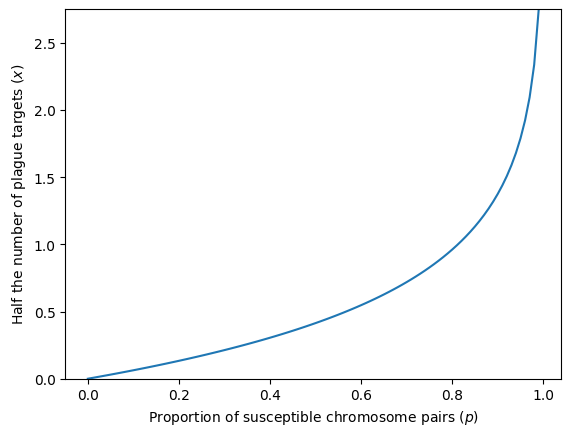

In [6]:
def f(p_array): # returns x-values
	if np.any(p_array < 0) or np.any(p_array >= 1):
		raise ValueError('domain error, [0,1)')
	return np.log(1-p_array) / (np.log(3) - 4*np.log(2))

p_values = np.linspace(0, 1, 100, endpoint=False) # 100 values from [0,1)
x_values = f(p_values)

plt.plot(p_values, x_values) # scatter plot
plt.xlabel('Proportion of susceptible chromosome pairs ($p$)')
plt.ylabel('Half the number of plague targets ($x$)')
plt.ylim(0, max(x_values))  # p-axis from 0 to the maximum x
plt.show()

In [7]:
import math
# Let's find out how many targets we need to make at least 99.9% of our starting population corrupted:
p = 0.999
x = f(p)
x = math.ceil(x) # we need a whole number of genes to target
p = p_infected(x)
print(f'To corrupt {p:.2%} of the population, the plague must have target {2*x} traits.\n=> x = {x}')

To corrupt 99.98% of the population, the plague must have target 10 traits.
=> x = 5


We will now try this problem with our default evolution cycle, from the last problem, breeding the strongest.

For now, we will set the __mutation rate__ to 0, so we observe the effects of only crossover.

Note that the health of an individual starts at $5n$, and is _decreased by_ $5$ pts for each phenotype they have which is susceptible to the plague.

We will give the DNA sequence for individuals a size of 30, and set $x=5$.

- Max fitness: $150 = 30\cdot 5$
- Min fitness: $100 = 150 - 5(2)\cdot 5$

Let's try to achieve full immunity!

In [8]:
random.seed(16) # for reproducibility

dna_length = 30 # each chromosome will be a list of 30 genes
Individual.MUTATION_RATE = 0

plague_x = Plague(dna_length, 5)
print(plague_x)

Targets
gene 0: a
gene 7: h
gene 9: j
gene 11: L
gene 12: m
gene 15: P
gene 16: q
gene 17: R
gene 20: U
gene 21: V


In [9]:
problem_state = random.getstate()
pop = Population(dna_length, plague_x)
print(pop)

Generation 0
	member 1, health: 130
	member 2, health: 130
	member 3, health: 130
	member 4, health: 130
	member 5, health: 125
	member 6, health: 120
	member 7, health: 120
	member 8, health: 105


In [65]:
# run another generation of the genetic algorithm
pop.evolve(display=True)

Generation 56
	member 1, health: 140
	member 2, health: 140
	member 3, health: 140
	member 4, health: 140
	member 5, health: 140
	member 6, health: 140



Hmmm, _strange_.

It seems like no matter how many generations pass, we can _never_ achieve any immunity!

We are stuck in a cycle of producing susceptible children for the next generation,  
while the previous generation dies off.

Let's investigate:

In [66]:
# we will display the genotypes susceptible to the plague,
# for each individual
i = 0
for m in pop.members:
	i += 1
	print(f'Member {i}')
	m.show_bad_genes()
	print()

Member 1
Weaknesses:
gene 11: LL
gene 12: mm

Member 2
Weaknesses:
gene 11: LL
gene 12: mm

Member 3
Weaknesses:
gene 11: LL
gene 12: mm

Member 4
Weaknesses:
gene 11: LL
gene 12: mm

Member 5
Weaknesses:
gene 11: LL
gene 12: mm

Member 6
Weaknesses:
gene 11: LL
gene 12: mm



No wonder!

Every member in the population seems to have the same weaknesses.  
So how can a child ever correct its genes, if both parents have the same defect?

We would be waiting for random mutation to favorably inject the resistant alleles into the population.

Since we've turned mutation off (for now), there is no possible way for our population to continue evolving—they're stuck with permanently bad genetics.  
The plague wins.

But why is this happening?

This is a genetic result I like to call &hellip;

## The Royal Family Problem

When parents who share very similar DNA have children, _inbreeding_, the children are more likely to have genetic defects.

European Royal families were known for inbreeding throughout history to keep their blood lines _pure_—to ensure 
they were marrying someone of equal _status_ and to protect their royal assets.   
The observable result was many royal members of the family developing horrible genetic disorders.  

For instance, __haemophilia__ in the British monarchy, which prevented the blood from properly clotting, caused death by bleeding out.

These disorders are due to detrimental __recessive alleles__.  
- An allele is a particular variation of a gene.

- A recessive allele indicates that the genetic trait it codes for does not affect the individual on its own.

- Two copies of the same allele, one inherited from each parent, must be present for the genetic trait (__genotype__) to be expressed (__phenotype__).

When parents are related, they share similiar DNA, and have a greater chance to carry the same alleles.  
Then, the child is more likely to be disabled by recessive genes that have a negative effect on the individual when expressed.

But why do recessive alleles necessarily carry negative effects?  
Remember, evolution ensures only the strongest survive.

Dominant alleles override recessive alleles and are expressed on their own (with at least one being inherited).  
Therefore, dominant alleles are expressed more often.  
Furthermore, dominant alleles existing in a population that lead to sickness or weakness will kill off the individual, and are then removed from the gene pool.  
Over time, only healthy dominant alleles will remain, but since recessive alleles get passed on without necessarily being expressed, they can 

So it's not that recessive genes are always dangerous.  
It's just that dominant alleles are optimized over time, whereas harmful recessive alleles can _hide_ in carriers, only showing up later.


## What does this mean for our genetic algorithm?

Well, we are inbreeding.

Think about it, after each generation the strongest members of the population multiply.  
We can assume that stronger parents will make stronger children.  
But then we are breeding the strongest of the population yet again?  

This means the relatives are continually producing more offsping until we create our own "royal family."  
At which point, there is a lack of genetic diversity to advance our population, and progress stagnates.

This is a result of allele extinction—when a partcular gene variant is completely removed from a population.  
And this is more likely to happen with inbreeding, because related individuals are more likely to have similar genes.

Consequently, if individuals with __homozygous genotypes__ (2 indentical alleles for a certain gene) mate,  
the children will not be able to inherit the alternate allele.  
Then, all descendants of the children will have a constant genotype for that trait.

Since our population only consists of 1 large family, once genetic information is lost,  
we would have to wait for random mutation to add that information back to the gene pool.

And if we increase the mutation rate, then our good solutions wouldn't be stable because those could mutate too.  
This would result in children that could get wildly better or worse each generation—complete madness!

The solution is to keep a greater variety of individuals in the population.

__This can be achieved through:__
- Mating with _outsiders_ (adding new random members to the population to breed with)

- Mating with not only the strongest, but other parents too.  
Even if they aren't as healthy, they may still hold beneficial genes that the strong members don't have.

- Include a fitness penalty for every additional individual that is too similar to the others.

- Mutate less-fit individuals more aggressively to add new material to the gene pool.

- Introduce elite archetypes into the starting population who cannot die.  
Their genes must represent vastly different solutions that remain to preserve genetic information.

- Rotate selection pressure—periodically change the criteria for strong individuals.

The idea here is that a greater mixture in genetic information will prevent our population from all becoming _clones_ of each other, and let our solutions mainatin evolution.   
Additionally, even if a parent has seemingly worse genetics overall, certain genes may still be better, allowing for the possibility of improved children.

> With a lack of genetic diversity, our population may converge to an unoptimal solution.

Imagine optimizing a bimodal function.  
We don't want to get stuck on a local minimum.  
Therefore, including some imprecision in our search space allows us to keep exploring solutions, while keeping our best guesses (strongest members) intact.

Let's see what happens to a single genotype when we start with 2 `Aa` parents, and create a _royal family_.

In [67]:
# For example
def example():
	parent_1 = 'Aa'
	parent_2 = 'Aa'

	def make_child(p1, p2):
		child = ''
		for p in (p1, p2):
			i = random.randint(0,1)
			child += p[i]
		return child

	family_tree = [parent_1, parent_2] # all related to the first 2 parents
	generation = 0
	for _ in range(100):
		for _ in range(2): # make 2 new inbred children
			c = make_child(family_tree[-2], family_tree[-1])
			family_tree.append(c)
		generation += 1
		if family_tree[-1] == family_tree[-2]:
			if family_tree[-1] in ('AA', 'aa'):
				break # lost genetic information
	
	print(f'{generation} generations passed.\n')
	print('Family Tree:')
	for i in range(0, len(family_tree), 2):
		print(f'{family_tree[i]}, {family_tree[i+1]}')
	
example()

4 generations passed.

Family Tree:
Aa, Aa
aA, Aa
aA, AA
aA, AA
AA, AA


Eventually, the _royal family_ converges to only `AA` or `aa` individuals.
And this can happen pretty fast.

Even without allele extinction, there is still a problem that may slow down our genetic algorithm.

This issue involves _carriers_.

A carrier is an individual who carries a recessive allele associated with a disease, but is not himself infected.  
This is because the secondary allele dominates the harmful one, masking the negative trait.

For instance:  
- `Bb`carries the `b` allele which causes a vulnerability to some disease.

- `Bb` expresses the `B-phenotype` because `B` is dominant.

- Only the `b-phenotype` can become infected.

- Therefore, an individual with `Bb` will not get infected, but his children might if they receive a `b` from both parents.

## Carriers & Inbreeding

Let's say we have 2 parents who are both carriers of a negative recessive allele, `b`.

Each parent has the genotype: `Bb`

Then we have 4 possible genotypes for the child:
- `BB`
- `Bb`
- `bB`
- `bb`

That is a $25\%$ chance to obtain the harmful recessive trait.

Let's say an individual of one family is a carrier of `h` harmful alleles.

We can assume it is likely a sibling of this family member is a carrier of the same alleles, since they share similar genetics.

Then, the chance of their child _not_ receiving any recessive traits is: $\ 0.75^h$

In other words, the probability that the child has _at least 1_ harmful recessive trait is:

$$1 - (0.75)^h$$

In [68]:
# Probability that a child will be born with at least one negative trait,
# given the parents are related and each carry h harmful recessive alleles.
def p_harmful_trait(h):
	return 1 - (0.75 ** h)

for h in range(21):
	print(f'Carrier of {h}: {p_harmful_trait(h):.2%}')

Carrier of 0: 0.00%
Carrier of 1: 25.00%
Carrier of 2: 43.75%
Carrier of 3: 57.81%
Carrier of 4: 68.36%
Carrier of 5: 76.27%
Carrier of 6: 82.20%
Carrier of 7: 86.65%
Carrier of 8: 89.99%
Carrier of 9: 92.49%
Carrier of 10: 94.37%
Carrier of 11: 95.78%
Carrier of 12: 96.83%
Carrier of 13: 97.62%
Carrier of 14: 98.22%
Carrier of 15: 98.66%
Carrier of 16: 99.00%
Carrier of 17: 99.25%
Carrier of 18: 99.44%
Carrier of 19: 99.58%
Carrier of 20: 99.68%


Wow, as a carrier of just a few poor alleles the potential for a genetically disordered child increases dramatically.

#### Let's plot this relationship!

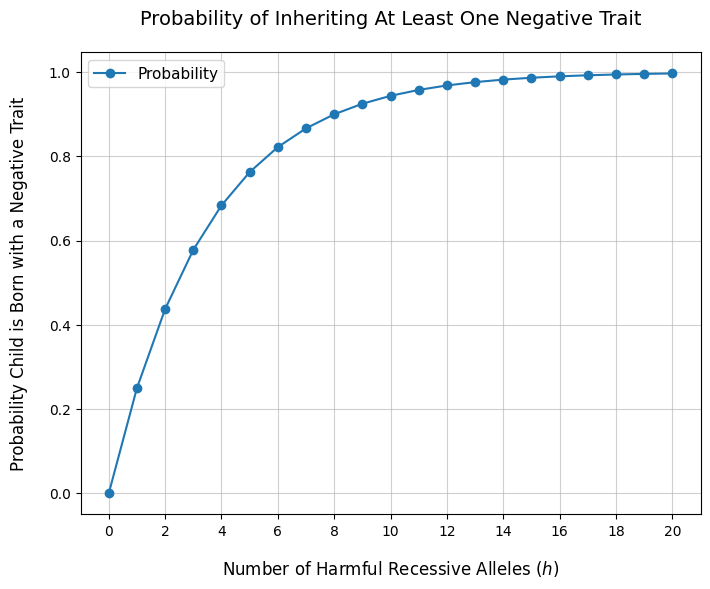

In [69]:
# Define the range of h values (number of harmful recessive alleles)
h_values = np.arange(0, 21, 1) # 0..20 harmful alleles

# Calculate the probability of inheriting at least one negative trait
prob_negative_trait = p_harmful_trait(h_values)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(h_values, prob_negative_trait, marker='o', label='Probability')

# Customize the plot
plt.title('Probability of Inheriting At Least One Negative Trait', fontsize=14, pad=20)
plt.xlabel('Number of Harmful Recessive Alleles ($h$)', fontsize=12, labelpad=15)
plt.ylabel('Probability Child is Born with a Negative Trait', fontsize=12, labelpad=15)
plt.xticks(np.arange(0, 21, 2), fontsize=10) # Adjust x-axis ticks to go by 2s
plt.yticks(fontsize=10)
plt.grid(True, linestyle='-', alpha=0.6)
plt.legend(fontsize=11)

plt.show()

Now, let's finally fix our genetic algorithm so we can defeat the plague!

We will maintain genetic diversity by `"mating with outsiders"`.

In [70]:
# We will choose outsiders to mate with
# We randomly create a new individual to join the strongest 2 members
#
# We can even ensure the new individual doesn't have immunity 
#  to highlight the benefit of genetic variation, even when the genes aren't optimal (immune)
def select_II(self: Population):
	strongest_2 = self.members[:2]
	dna_length = strongest_2[0].length
	plague = strongest_2[0].plague
	outsider = Individual(dna_length, plague)
	# mutate single gene until susceptible
	i = 0
	while outsider.fitness >= outsider.HEALTH_UNIT * outsider.length: # max health
		outsider.chromosomes[0][i] = Individual.swap_char_case(outsider.chromosomes[0][i])
		outsider.evaluate_fitness()
		i += 1
	return strongest_2 + [outsider] # greater variety

Population.select = select_II

In [71]:
# Let's try this again!
random.setstate(problem_state) # same initial population as before

pop = Population(dna_length, plague_x)
print(pop)

Generation 0
	member 1, health: 130
	member 2, health: 130
	member 3, health: 130
	member 4, health: 130
	member 5, health: 125
	member 6, health: 120
	member 7, health: 120
	member 8, health: 105


In [85]:
# run another generation of the genetic algorithm
pop.evolve(display=True)

Generation 14
	member 1, health: 150
	member 2, health: 150
	member 3, health: 150
	member 4, health: 150
	member 5, health: 150
	member 6, health: 150
	member 7, health: 150
	member 8, health: 150



We have achieved full immunity—our population lives on!

The lesson here is to __maintain genetic diversity__ to prevent convergence to an unoptimal solution,  
or to avoid _royal families_ when encoding data with multiple parts (chromosomes).

Next, we will attempt to create a general-purpose genetic algorithm package to use as a base for any GA problem in the futue.

### __Useful Links__

- [Pyvolver Package](./pyvolver)

- [Number of Parents](./num_parents.ipynb)

- [Find the Global Max](./avoid_the_plague.ipynb)